---
date: last-modified
---

# NetCDF to CSV Transformation

## Summary

This notebook demonstrates an approach for converting a Network Common Data Form (netCDF4) file from the [Multi-Angle Imager for Aerosols (MAIA)](https://asdc.larc.nasa.gov/project/MAIA) instrument into a Comma Separated Value (CSV) file.

## Outline

- The NetCDF file is opened using `nc.Dataset` in read mode.
- A dictionary called `data_dict` is created to store data from each variable. The `read_variables` function populates the dictionary.
- The maximum length among the variable data arrays is determined.
- Variables with shorter lengths are padded to match the maximum length using `numpy.resize`. The updated variable data arrays are stored back in the `data_dict` variable.
- A pandas DataFrame called `data` is created using the data_dict dictionary, where each variable becomes a column in the DataFrame.
- The DataFrame is saved to a CSV file. The `index=False` argument is used to exclude the row index from being written to the CSV file.

## Prerequisites

- `netCDF4` - for reading netCDF files
- `numpy` - for array operations
- `pandas` - for data manipulation

### Notebook Author / Affiliation

Hazem Mahmoud / Atmospheric Science Data Center

## 1. Setup

In [ ]:
import netCDF4 as nc
import pandas as pd
import numpy as np

## 2. NetCDF conversion to CSV

In [ ]:
def read_variables(group):
    """
    Recursive function to read variables from a NetCDF group and its subgroups.

    Parameters:
        group

    Returns:
        a dictionary containing variable names as keys and their corresponding data arrays as values.
    """
    data_dict = {}

    # Iterate over variables in the current group
    for var in group.variables:
        var_data = group.variables[var][:]

        # Flatten the variable data if it has more than one dimension
        if len(var_data.shape) > 1:
            var_data = var_data.flatten()

        data_dict[var] = var_data

    # Iterate over subgroups in the current group
    for subgroup in group.groups.values():
        subgroup_data = read_variables(subgroup)
        data_dict.update(subgroup_data)

    return data_dict

In [ ]:
def netcdf_to_csv(input_file, output_file):
    dataset = nc.Dataset(input_file, "r")  # Open the NetCDF file in read mode

    # Create a dictionary to store the variable data
    data_dict = read_variables(dataset)

    # Find the maximum length among the variable data
    max_length = max(var_data.size for var_data in data_dict.values())

    # Pad variables with shorter lengths to match the maximum length
    for var in data_dict:
        var_data = data_dict[var]
        if var_data.size < max_length:
            var_data = np.resize(var_data, max_length)
            data_dict[var] = var_data

    # Create a pandas DataFrame using the data dictionary
    data = pd.DataFrame(data_dict)

    # Save the DataFrame to a CSV file
    data.to_csv(output_file, index=False)

    print("Conversion complete.")


# Usage example
input_file = "/content/MAIA_L4_GFPM_20180101T000000Z_FB_NOM_R01_USA-Boston_F01_VSIM01p01p01p01.nc"
output_file = "/content/output.csv"

netcdf_to_csv(input_file, output_file)

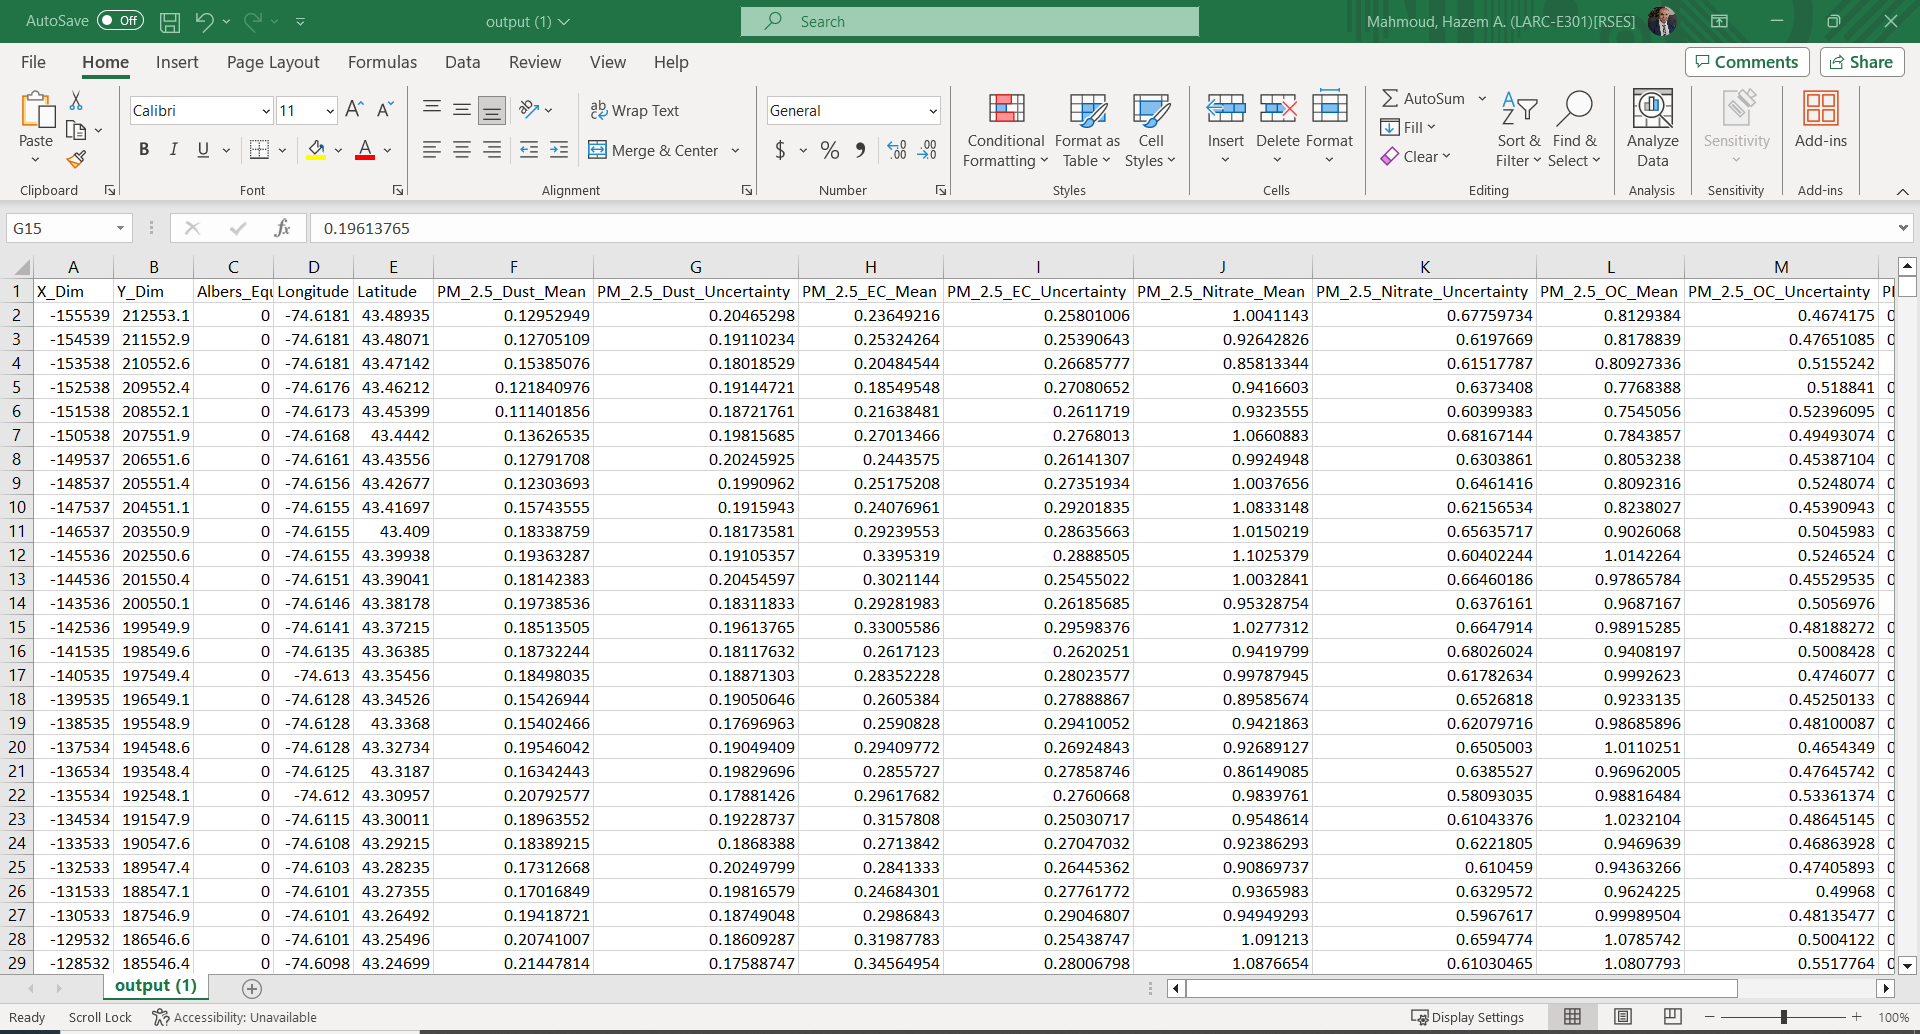